In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
import time
from IPython import display
import tqdm
from tensorflow.keras import utils

import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---  
**CONFIG**

In [ ]:
BATCH_SIZE = 256
IMG_SIZE = 128
EPOCHS = 200
GIF = False

---

In [ ]:
def to_gray_and_resize(img):
    img = img.resize((IMG_SIZE,IMG_SIZE),resample=PIL.Image.BICUBIC)
    img = np.asarray(img).astype(np.float32)
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = (r + g + b) / 3 
    return gray

def get_rgb_images(file):
    if ".jpg" in file:
        im = PIL.Image.open(file)
        im = to_gray_and_resize(im)
        return im
    else:
        im = PIL.Image.open(file).convert('RGBA')
        im.load()
        new_im = PIL.Image.new("RGB", im.size, (255, 255, 255))
        new_im.paste(im, mask = im.split()[3])
        new_im = to_gray_and_resize(new_im)
        return new_im
    
def read_images(path):
    all_imgs = []
    for image_name in tqdm.tqdm_notebook(next(os.walk(path), (None, None, []))[2]):
        img = get_rgb_images(path+'/'+image_name)
        all_imgs.append(img)
    return np.array(all_imgs)

In [ ]:
all_images = read_images('drive/MyDrive/Pics/cat')

<ipython-input-4-f774b65884a1>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_name in tqdm.tqdm_notebook(next(os.walk(path), (None, None, []))[2]):


  0%|          | 0/4270 [00:00<?, ?it/s]

In [ ]:
all_images[0].shape

(128, 128)

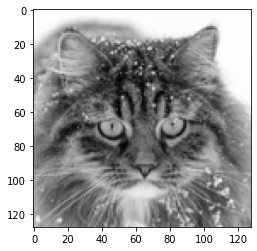

In [ ]:
plt.imshow(all_images[0], cmap='gray')

In [ ]:
train_images = all_images.reshape(all_images.shape[0], IMG_SIZE, IMG_SIZE, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
# BUFFER_SIZE = all_images.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(IMG_SIZE).batch(BATCH_SIZE)

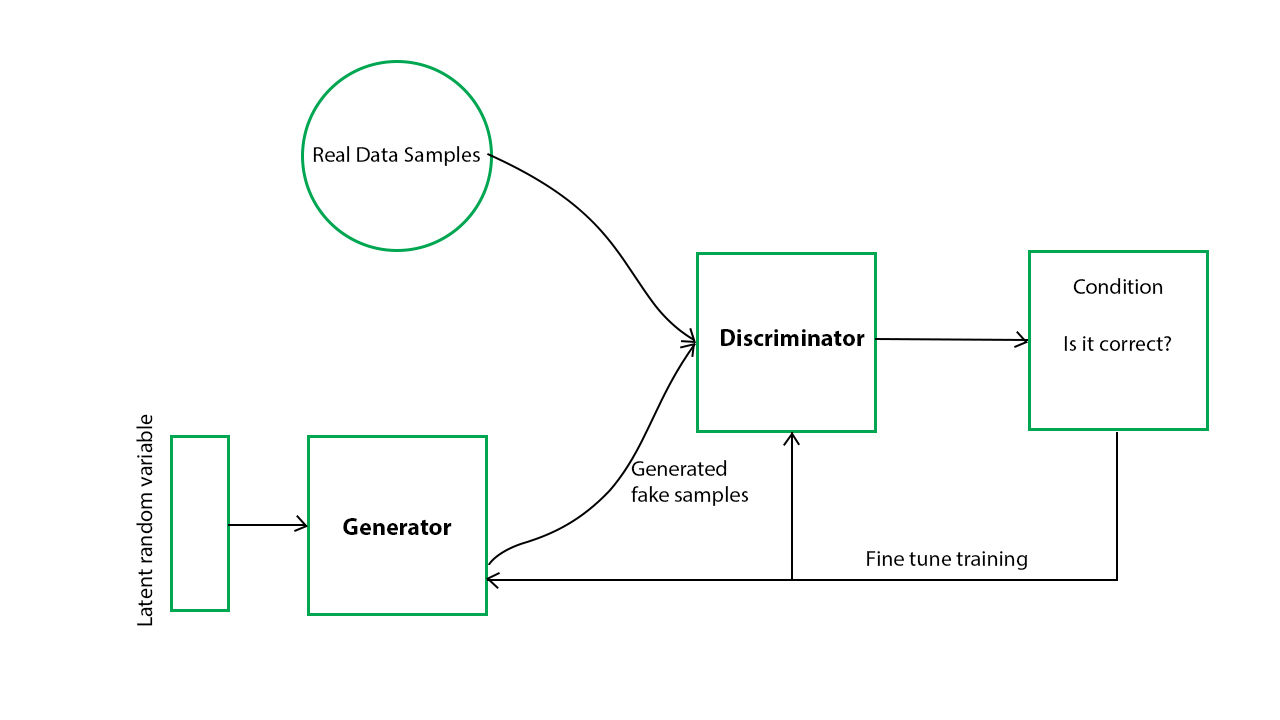

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense((IMG_SIZE // 8) * (IMG_SIZE // 8) * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((IMG_SIZE // 8, IMG_SIZE // 8, 256)))
    assert model.output_shape == (None, IMG_SIZE // 8, IMG_SIZE // 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE // 4, IMG_SIZE // 4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE // 2, IMG_SIZE // 2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (8, 8), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 1)

    return model

 


*   Про BatchNormalization: https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad
*   Ниже иллюстрация работы Conv2DTranspose



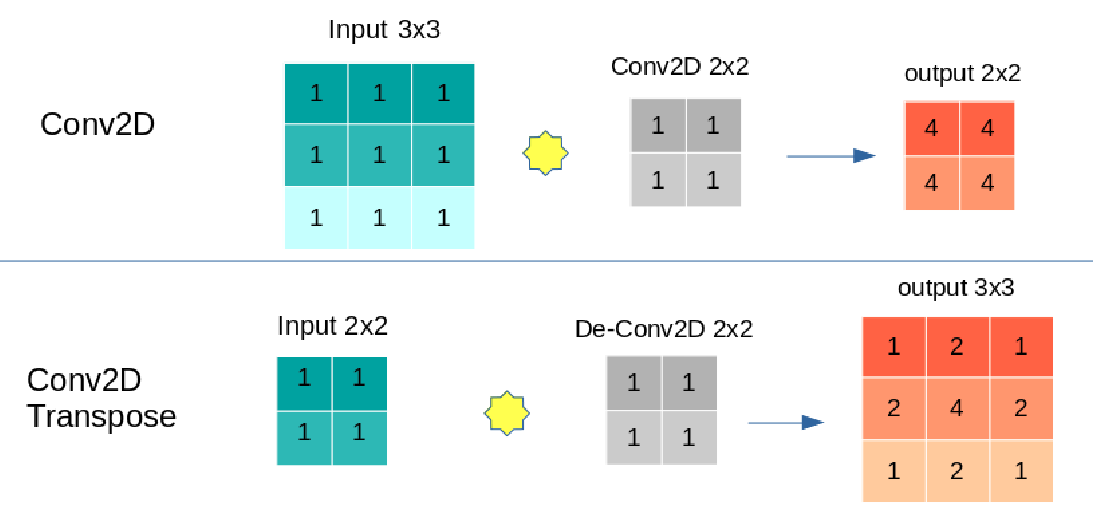

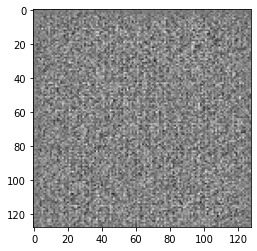

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    # model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[2.373723e-05]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       1280      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        131136    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 65536)           

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs, gif=False):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed, gif)

    # Save the model every 100 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed, gif)

In [ ]:
def generate_and_save_images(model, epoch, test_input, gif):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # if gif:
  #     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

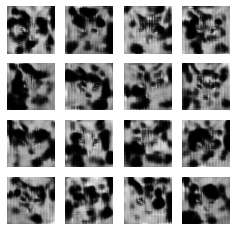

In [ ]:
train(train_dataset, EPOCHS, False)

In [ ]:
# if GIF:
#     anim_file = 'dcgan.gif'

#     with imageio.get_writer(anim_file, mode='I') as writer:
#       filenames = glob.glob('image*.png')
#       filenames = sorted(filenames)
#       for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
#       image = imageio.imread(filename)
#       writer.append_data(image)

#     import tensorflow_docs.vis.embed as embed
#     embed.embed_file(anim_file)

In [ ]:
def to_np_0_255(img):
    norm_image = cv2.normalize(img.numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    return norm_image

def gen_and_plot_image():
    seed = tf.random.normal([1, 100])
    gen_img = generator(seed, training=False)
    gen_img = to_np_0_255(gen_img[0])
    plt.imshow(gen_img, cmap='gray')

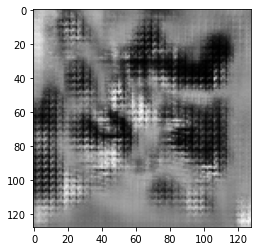

In [ ]:
gen_and_plot_image() # after 200

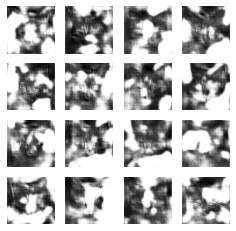

In [ ]:
train(train_dataset, 200, GIF)

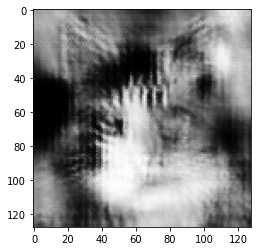

In [ ]:
gen_and_plot_image() # after 400

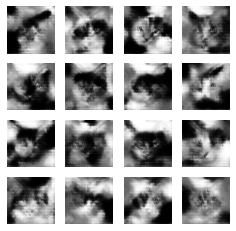

In [ ]:
train(train_dataset, 200, GIF)

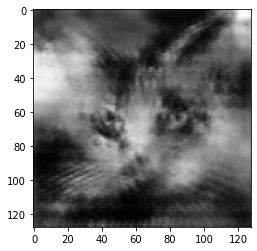

In [ ]:
gen_and_plot_image() # after 600

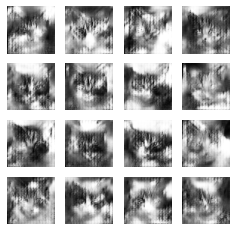

Time for epoch 49 is 14.024458169937134 sec


In [ ]:
train(train_dataset, 200, GIF)

In [ ]:
gen_and_plot_image() # 800

In [ ]:
train(train_dataset, 200, GIF)

In [ ]:
gen_and_plot_image() # 1000